In [1]:
# Required packages and data paths
# Scanpy 1.8
import scanpy as sc
import anndata as ad
import episcanpy.api as epi
import pandas as pd

STUD_PATH = '/mnt/workspace_stud/'
OUTPUT_PATH = f'{STUD_PATH}stud2/output/'
GTF_PATH = f'{STUD_PATH}mbentse/homo_sapiens/homo_sapiens.104.mainChr.gtf'

In [32]:
# define input path and output directories
TISSUE = "liver_sample_9"
INPUT_PATH = f'{OUTPUT_PATH}wp1/{TISSUE}_pp17.h5ad'
output_wp4 = f"{OUTPUT_PATH}wp4/{TISSUE}_obs.csv"
output_wp3 = f"{OUTPUT_PATH}wp3/clusters_{TISSUE}.tsv"
output_sc_csv = f"{OUTPUT_PATH}wp1/scanpy.csv"

In [3]:
# read input file and check matrix size
adata = ad.read(INPUT_PATH)
adata

AnnData object with n_obs × n_vars = 15588 × 958895
    obs: 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    layers: 'binary', 'normalised'

In [4]:
# calculate log
epi.pp.log1p(adata)

### Calculate neighbours and clusters

In [5]:
# prepare neighbours for clustering
sc.pp.pca(adata, n_comps=50, svd_solver='arpack', use_highly_variable=False)
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=50, method='umap', metric='euclidean')

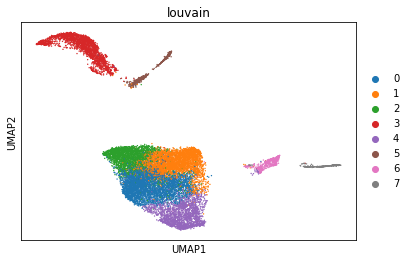

In [8]:
# calculate umap and cluster find clusters with louvain
# Umap: spread = 2.0, min_dist = 0.1
# Louvain: resolution = 0.5 - 0.8
sc.tl.umap(adata, min_dist=0.1, spread=2.0)
epi.tl.louvain(adata, resolution=0.7, use_weights=True)
epi.pl.umap(adata, color=['louvain'])

### Write cluster files

In [7]:
# write files for wp4/3
with open(output_wp4, "w") as obs_file, open(output_wp3, "w") as tsv_file:
    line = "barcode\tcluster\n"
    obs_file.write(line)
    tsv_file.write(line)
    for barcode in range(len(adata.obs.index)):
        line = f"{adata.obs.index[barcode]}\t{adata.obs['louvain'][barcode]}\n"
        obs_file.write(line)
        tsv_file.write(line)

### Find features / genes

In [9]:
epi.tl.find_genes(adata,
           gtf_file=GTF_PATH,
           key_added='gene_annotation',
           upstream=2000,
           feature_type='gene',
           annotation='ensembl_havana',
           raw=False)

adata.var['gene_annotation']

chr1_9955_10355           intergenic
chr1_29163_29563          intergenic
chr1_267803_268203        intergenic
chr1_633354_633754        intergenic
chr1_727023_727423        intergenic
                             ...    
chrY_56676947_56677347    unassigned
chrY_56677442_56677842    unassigned
chrY_56678029_56678429    unassigned
chrY_56678600_56679000    unassigned
chrY_56707025_56707425    unassigned
Name: gene_annotation, Length: 958895, dtype: object

## Write bed files

In [ ]:
for cluster in adata.obs['louvain'].unique():
    cluster_adata = adata[adata.obs['louvain'] == cluster]
    epi.pp.filter_features(cluster_adata, min_cells=1)
    cluster_path = f'{OUTPUT_PATH}wp1/{TISSUE}_cluster_{cluster}.bed'
    with open(cluster_path, 'w') as cl_output:
        for peak in cluster_adata.var.index:
            tmp = peak.replace('_', '\t')
            cl_output.write(f"{tmp}\n")

### Filter unassigned / intergenic features

In [54]:
assigned_features = adata.var[adata.var['gene_annotation'] != "intergenic"]
assigned_features = assigned_features[assigned_features['gene_annotation'] != "unassigned"]
assigned_adata = adata[:, assigned_features.index]

assigned_adata

View of AnnData object with n_obs × n_vars = 15588 × 536762
    obs: 'nb_features', 'log_nb_features', 'louvain'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score', 'gene_annotation'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'binary', 'normalised'
    obsp: 'distances', 'connectivities'

### Replace peaks with gene names

In [55]:
names = []

for n in assigned_adata.var['gene_annotation'].values:
    n = n.split(';')
    names.append(n[0])
    #names.append(n)
    
assigned_adata.var_names = pd.Index(names)

In [56]:
# make new feature names unique and write them into raw
assigned_adata.var_names_make_unique()
assigned_adata.raw = assigned_adata

### Rank genes

... storing 'gene_annotation' as categorical


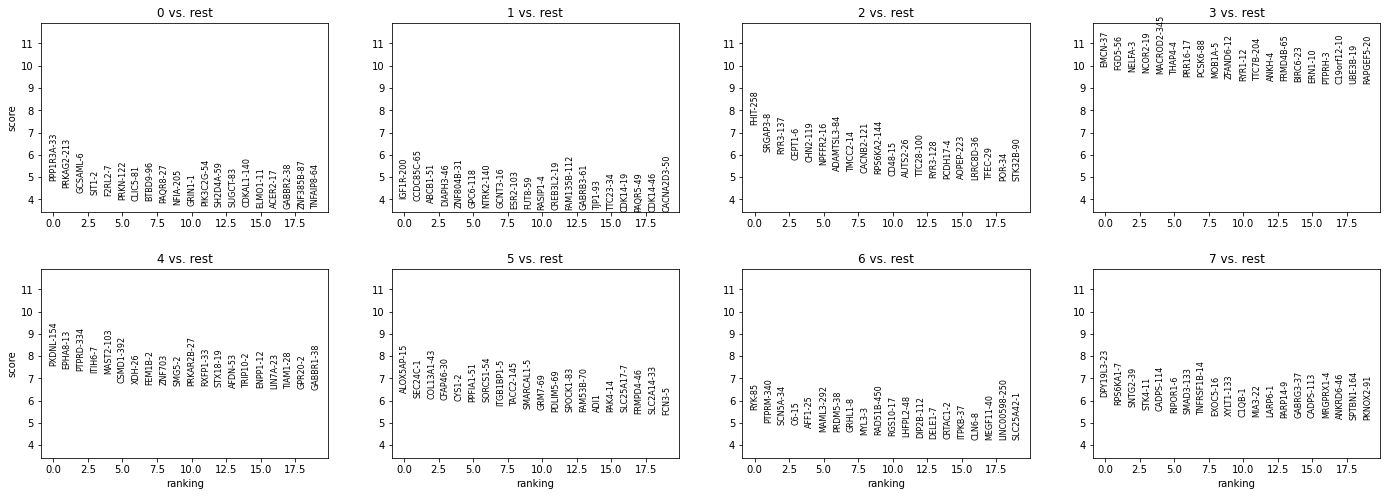

In [57]:
sc.tl.rank_genes_groups(assigned_adata, groupby='louvain', use_raw=False)
#sc.tl.filter_rank_genes_groups(assigned_adata, groupby='louvain', use_raw=False)
sc.pl.rank_genes_groups(assigned_adata)

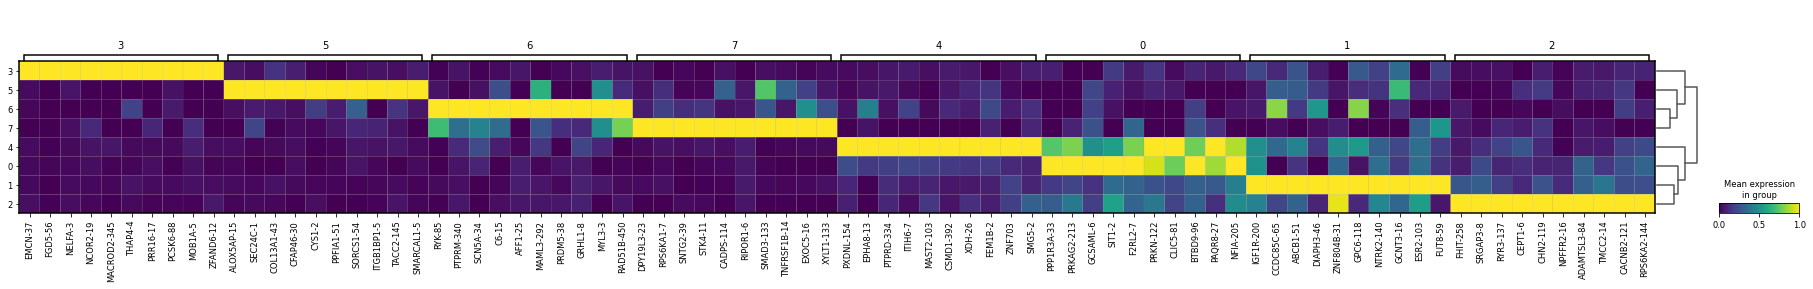

In [58]:
sc.pl.rank_genes_groups_matrixplot(assigned_adata, standard_scale='var', n_genes=10)

### Converting to csv for SCSA

In [59]:
result = assigned_adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
dat = pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'logfoldchanges','scores','pvals']})
dat.to_csv(output_sc_csv)

In [60]:
pd.DataFrame(assigned_adata.uns['rank_genes_groups']['names']).head(100)

,0,1,2,3,4,5,6,7
0,PPP1R3A-33,IGF1R-200,FHIT-258,EMCN-37,PXDNL-154,ALOX5AP-15,RYK-85,DPY19L3-23
1,PRKAG2-213,CCDC85C-65,SRGAP3-8,FGD5-56,EPHA8-13,SEC24C-1,PTPRM-340,RPS6KA1-7
2,GCSAML-6,ABCB1-51,RYR3-137,NELFA-3,PTPRD-334,COL13A1-43,SCN5A-34,SNTG2-39
3,SIT1-2,DIAPH3-46,CEPT1-6,NCOR2-19,ITIH6-7,CFAP46-30,C6-15,STK4-11
4,F2RL2-7,ZNF804B-31,CHN2-119,MACROD2-345,MAST2-103,CYS1-2,AFF1-25,CADPS-114
...,...,...,...,...,...,...,...,...
95,ADGRB3-123,C5orf52-1,NHSL1-24,PCSK9-8,PSEN2-24,LHPP-92,RPGRIP1-12,TNFRSF11A-19
96,ZMAT4-151,TRPM1-72,MAGI2-152,ADAMTS12-107,IPCEF1-6,PAK6-37,ARHGAP44-18,RPS6KA5-38
97,ENPP6-44,NRXN3-283,SAXO1,TPRG1-140,LGR5-22,TMC7-2,DRD1-1,MAML3-173
98,TIAM2-40,MAN1A1-17,TBXAS1-96,SLC15A1-2,KATNIP-61,RAPGEF2-29,SHISAL2A-5,TNRC6B-119


### Create bash command to execute

In [61]:
python3 = "/home/stud2/.conda/envs/datanew/bin/python3.9"
scsa_loc = f"{STUD_PATH}stud2/SCSA/SCSA.py"
wholeDB_loc = f"{STUD_PATH}stud2/SCSA/whole.db"
input_csv = output_sc_csv
results_file = "result"
output_file = f"{OUTPUT_PATH}wp1/ergebnisse.txt"

scsa_cmd = f"{python3} {scsa_loc} -d {wholeDB_loc} -i {input_csv} -s scanpy -E -f1.5 -p 0.01 -o {results_file} -m txt"
scsa_cmd += f" | tail > {output_file}; cat {output_file}"
print(scsa_cmd)

/home/stud2/.conda/envs/datanew/bin/python3.9 /mnt/workspace_stud/stud2/SCSA/SCSA.py -d /mnt/workspace_stud/stud2/SCSA/whole.db -i /mnt/workspace_stud/stud2/output/wp1/scanpy.csv -s scanpy -E -f1.5 -p 0.01 -o result -m txt | tail > /mnt/workspace_stud/stud2/output/wp1/ergebnisse.txt; cat /mnt/workspace_stud/stud2/output/wp1/ergebnisse.txt


In [62]:
!$scsa_cmd


#Cluster Type Celltype Score Times
['0', 'Good', 'Meiotic prophase fetal germ cell', 0.29622314951983836, '-']
['1', '?', 'Follicular helper (Tfh) T cell|T cell', '3.3833125825961576|2.582713712456112', 1.3099835906236357]
['2', 'Good', 'Natural killer T (NKT) cell', 3.6599986723450657, 6.902156985675174]
['3', '?', 'Natural killer T (NKT) cell|Stem cell', '7.613353479364447|4.928869121233978', 1.5446450883764566]
['4', '?', 'Endothelial cell|Mesenchymal stem cell', '5.751886168356755|3.894853244074963', 1.4767915009652288]
['5', '?', 'Follicular helper (Tfh) T cell|Natural killer T (NKT) cell', '3.8937363522308974|3.5317887709359304', 1.1024827940655835]
['6', '?', 'B cell|Plasma cell', '4.098128912200856|3.64352085751351', 1.1247716350380905]
['7', '?', 'T cell|Mesenchymal stem cell', '4.598363495763647|4.433524811871718', 1.0371800521901982]
